#Bayesian Logistic Regression

Install PYMC3: https://pymc-devs.github.io/pymc3/#installation

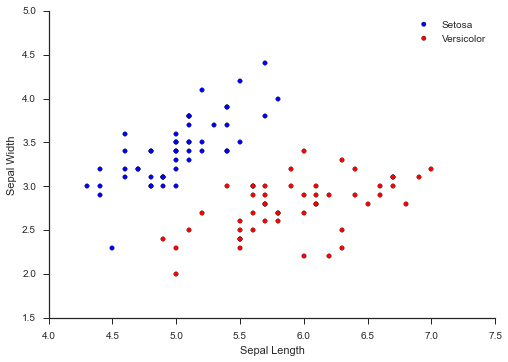

In [32]:
import pymc3 as pm
from sklearn import datasets
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set(style='ticks', palette='Set2')
import pandas as pd
import numpy as np
import math
from theano import tensor
from __future__ import division

data = datasets.load_iris()
X = data.data[:100, :2]
y = data.target[:100]
X_full = data.data[:100, :]

setosa = plt.scatter(X[:50,0], X[:50,1], c='b')
versicolor = plt.scatter(X[50:,0], X[50:,1], c='r')
plt.xlabel("Sepal Length")
plt.ylabel("Sepal Width")
plt.legend((setosa, versicolor), ("Setosa", "Versicolor"))
sns.despine()

In [2]:
basic_model = pm.Model()
X1 = X[:, 0]
X2 = X[:, 1]

with basic_model:

    # Priors for unknown model parameters
    alpha = pm.Normal('alpha', mu=0, sd=10)
    beta = pm.Normal('beta', mu=0, sd=10, shape=2)

    # Expected value of outcome
    mu = alpha + beta[0]*X1 + beta[1]*X2
    logit = 1 / (1 + tensor.exp(-mu))

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Bernoulli('Y_obs', p=logit, observed=y)
    
    start = pm.find_MAP()
    step = pm.NUTS(scaling=start) # Instantiate MCMC sampling algorithm
    trace = pm.sample(2000, step, progressbar=False) # draw 2000 posterior samples using NUTS sampling

/Users/tylerfolkman/anaconda/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x10cdc2450>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1119791d0>]], dtype=object)

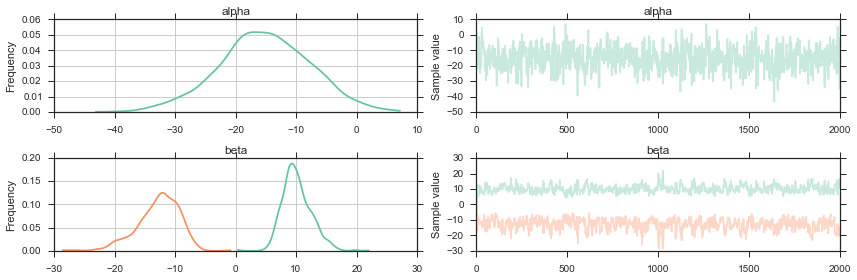

In [3]:
pm.traceplot(trace)

In [14]:
np.mean(trace.get_values('beta'), axis=0)

array([ 10.12441596, -12.76510469])

In [33]:
def predict(trace, x1, x2, threshold):
    alpha = trace.get_values('alpha').mean()
    betas = np.mean(trace.get_values('beta'), axis=0)
    linear = alpha + (x1 * betas[0]) + (x2 * betas[1])
    probability = 1 / (1 + np.exp(-linear))
    return [np.where(probability >= threshold, 1, 0), linear, probability]
def accuracy(predictions, actual):
    return np.sum(predictions == actual) / len(predictions)

In [34]:
predictions, logit_x, logit_y = predict(trace, X1, X2, 0.5)
accuracy(predictions, y)

0.98999999999999999

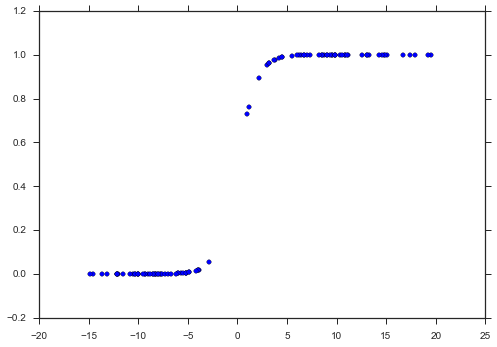

In [36]:
plt.scatter(logit_x, logit_y)